<a href="https://colab.research.google.com/github/gabrielxmit10/Repository_Telecom_Trab_EEG/blob/main/EEG_guigui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Analysis Notebook — PhysioNet (Motor Movement/Imagery) + CHB-MIT (seizure detection)

Este notebook 2 blocos principais:
1) Pipeline com o dataset *EEG Motor Movement/Imagery* (PhysioNet / BCI2000) cobrindo:
 - leitura e pré-processamento (filtragem, notch)
 - PSD / bandpower por banda + topomapas
 - espectrograma (STFT) e scalogram (CWT)
 - ICA: identificação e remoção de artefatos (ex.: piscadas)
 - ERP / média por evento (quando aplicável)
 2) Notebook curto para detecção de crises (CHB-MIT):
 - leitura de EDFs (exige download manual ou upload para Colab)
 - extração de features (bandpower, entropia, RMS)
 - classificação simples (RandomForest) em janelas

 Cite: Este notebook usa MNE-Python para manipulação de EEG, PyWavelets para CWT e scikit-learn para ML.





In [ ]:
#  0) Instalação das dependências

!pip install mne==1.4.2 pyedflib pywavelets scikit-learn matplotlib seaborn tqdm

In [ ]:
# 1) Importação de bibliotecas

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import mne
from mne.time_frequency import psd_array_welch
PSD_FUNC = psd_array_welch
from mne.preprocessing import ICA, create_eog_epochs
from mne.channels import make_standard_montage


import pywt
from scipy.signal import spectrogram


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report


print('mne version:', mne.__version__)

mne version: 1.4.2


O arquivo signal.edf já existe.
Extracting EDF parameters from /content/signal.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1343999  =      0.000 ...  2624.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG F3, EEG C3, EEG P3, EEG O1, EEG F7, EEG T3, EEG T5, ...
 chs: 35 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-01-01 19:39:33 UTC
 nchan: 35
 projs: []
 sfreq: 512.0 Hz
>


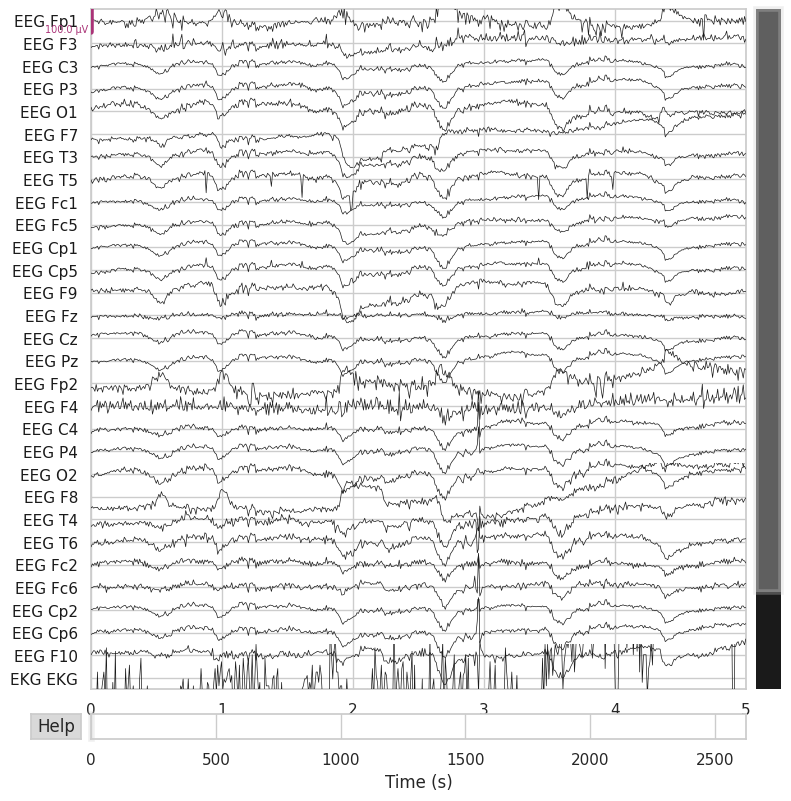

In [17]:
## 📥 Load EEG Data from PhysioNet

import mne
import os # Vamos usar a biblioteca 'os' para checar se o arquivo já foi baixado

# 1. Defina a URL exata de DOWNLOAD DIRETO
file_url = 'https://physionet.org/files/siena-scalp-eeg/1.0.0/PN00/PN00-1.edf'
local_file_name = 'signal.edf'

# 2. Baixa o arquivo da URL (apenas se ele ainda não existir nesta sessão)
if not os.path.exists(local_file_name):
    print(f'Baixando arquivo de {file_url}...')
    !wget -q -O {local_file_name} {file_url}
    print('Download completo.')
else:
    print(f'O arquivo {local_file_name} já existe.')

# 3. Carrega o arquivo .edf (o binário real) que acabamos de baixar
raw = mne.io.read_raw_edf(local_file_name, preload=True)
raw_original = raw

# 4. Informações básicas
print(raw.info)
raw.plot(duration=5, n_channels=30, scalings=50e-6)
None

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    3.4s finished


Fitting ICA to data using 35 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 73.1s.
Plotando as fontes (sinais) dos componentes ICA...
Creating RawArray with float64 data, n_channels=15, n_times=1344000
    Range : 0 ... 1343999 =      0.000 ...  2624.998 secs
Ready.


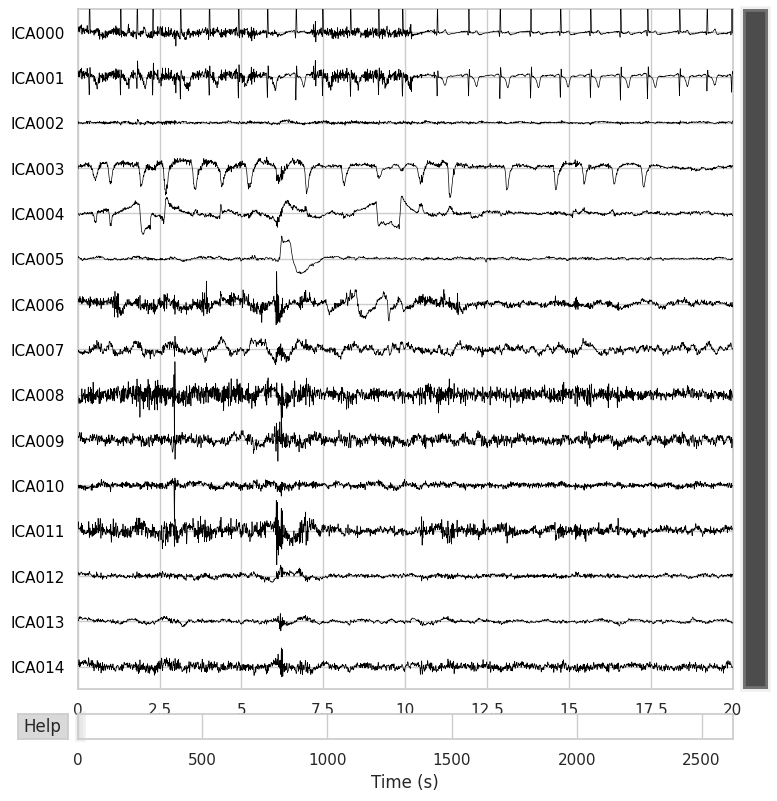

In [18]:
## 🧹 Preprocessing and Filtering
import numpy as np # Necessário para checar por 'NaN'
from mne.preprocessing import ICA

raw.load_data()

# Filtro passa-banda (tipicamente 1–40 Hz EEG)
raw.filter(1., 40., fir_design='firwin')

# Correção da nomeclatura dos canais
channel_names = raw.info['ch_names']
mapping = {name: name.replace('.', '').upper() for name in channel_names}
raw.rename_channels(mapping)

# Artifact detection using ICA
n_channels = len(raw.info['ch_names'])
n_components = 15

ica = ICA(n_components=n_components, random_state=97)
ica.fit(raw)

# --- NOVO PLOT ---
# Como não podemos usar ica.plot_components() (mapas da cabeça),
# vamos usar ica.plot_sources() para ver o SINAL de cada componente.
# Isso ainda nos permite identificar artefatos (como piscadas).
print("Plotando as fontes (sinais) dos componentes ICA...")
ica.plot_sources(raw)
None

## O que podemos ver sobre o sinal? (Análise dos Componentes)
Analisando a forma de onda de cada componente, podemos identificar vários artefatos clássicos. Os artefatos são "fáceis" de encontrar porque geralmente têm sinais muito fortes, rítmicos e com formas distintas:

- ICA000: Artefato de Batimento Cardíaco (ECG): Observe os picos agudos e perfeitamente rítmicos (cerca de 1 por segundo). Isso é o sinal elétrico do coração sendo captado pelos eletrodos do EEG. É um artefato clássico.

- ICA003, ICA004, ICA005: Artefatos de Olho (EOG): ICA004 e ICA005 mostram picos grandes, agudos e isolados (veja em 5s, 8s, 10s). Esta é a assinatura clássica de uma piscada de olho (blink). ICA003 mostra ondas mais lentas e "quadradas". Isso é típico de movimento lateral (lado a lado) dos olhos.

- ICA001: Artefato Muscular (EMG): É um sinal de alta frequência, "ruidoso" e irregular, mas constante. Isso é muito característico de ruído muscular, talvez de tensão na mandíbula ou no pescoço (músculos temporais ou cervicais).

- ICA014: Ruído de Baixa Frequência (Drift): Veja como a linha de base "flutua" muito lentamente. Isso é um ruído de "drift" (deriva da linha de base) que não representa atividade cerebral e geralmente é removido.

- ICA002, ICA006 a ICA013: Provável Atividade Cerebral: Estes componentes parecem mais "caóticos", sem um padrão rítmico óbvio e com menor amplitude. Este é o aspecto esperado da atividade neural misturada (as "conversas" do cérebro). Estes são os componentes que queremos manter.

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 15 ICA components
    Projecting back using 35 PCA components
Plotando o sinal ORIGINAL (com escala fixa):


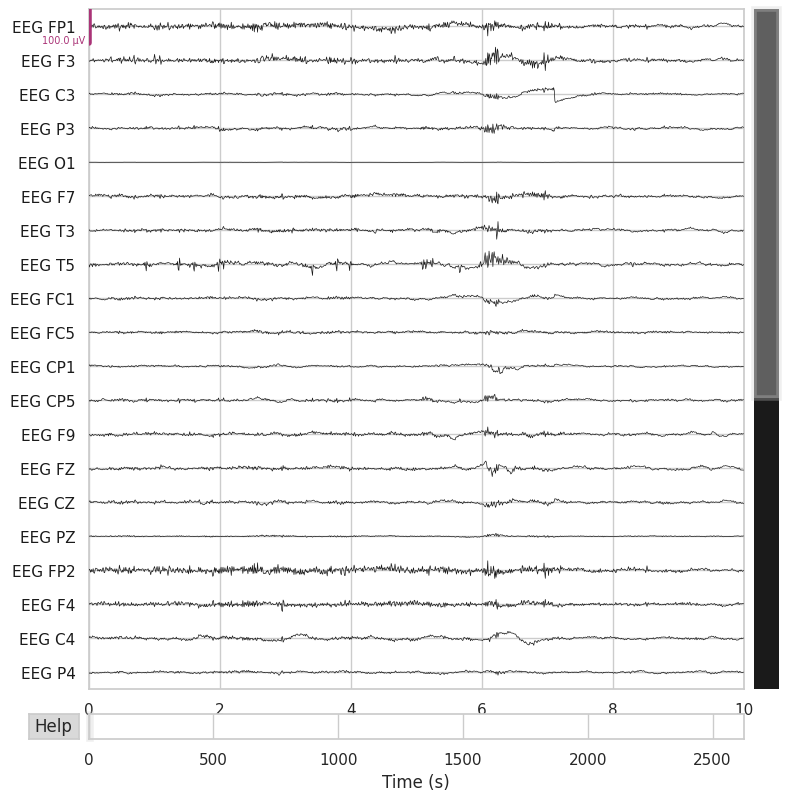


Plotando o sinal LIMPO (com escala fixa):


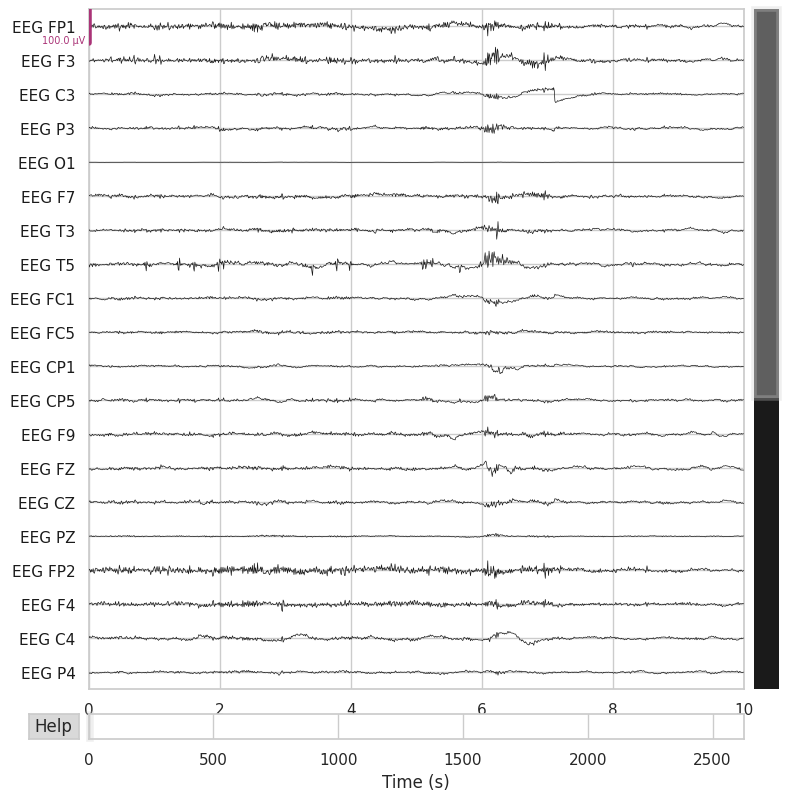

In [31]:
# Sinal Com e Sem os Artefatos removidos (usando ICA)

# 1. Identifique os componentes a serem excluídos
# (Com base na nossa análise visual)
componentes_ruins = [0, 1, 3, 4, 5, 14]

# 2. Adicione essa lista ao objeto 'ica'
ica.exclude = componentes_ruins

# 3. Aplique a limpeza.
# O MNE irá subtrair esses componentes ruins do seu sinal original
# e criar um novo objeto 'clean_signal'
clean_signal = ica.apply(raw)

# 4. Comparação do sinal original com o limpo
fixed_scaling = dict(eeg=50e-6)

print("Plotando o sinal ORIGINAL (com escala fixa):")
raw_original.plot(duration=10,
         n_channels=20,
         scalings=fixed_scaling,
         title='SINAL ORIGINAL (Escala 50µV)')

print()

print("Plotando o sinal LIMPO (com escala fixa):")
clean_signal.plot(duration=10,
               n_channels=20,
               scalings=fixed_scaling,
               title='SINAL LIMPO (Escala 50µV)')

None

Esses picos agudos que aparecem em vários canais ao mesmo tempo são a atividade epileptiforme (provavelmente "espículas" ou "ondas agudas" interictais – a atividade cerebral anormal entre as convulsões).

Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


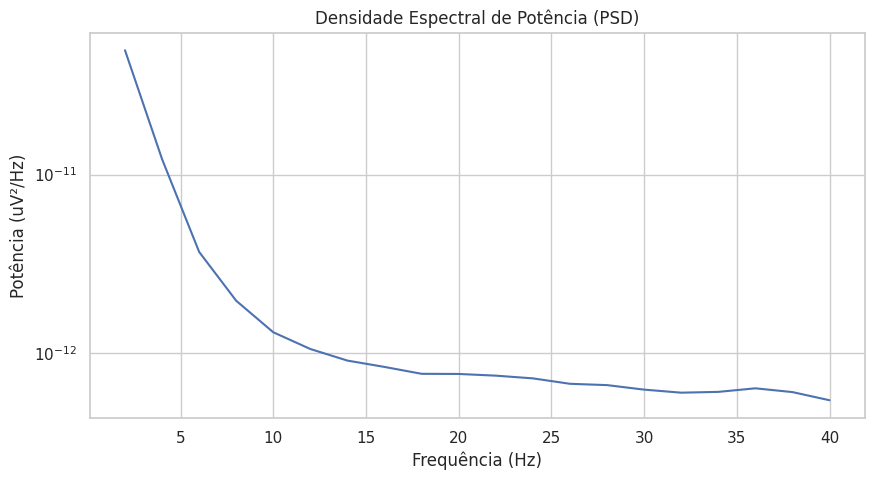

In [13]:
## ⚡ Power Spectral Density (PSD) Analysis

# Compute Power Spectral Density using Welch’s method
psds, freqs = PSD_FUNC(clean_signal.get_data(), sfreq=clean_signal.info['sfreq'], fmin=0.5, fmax=40)

# Average and plot
plt.figure(figsize=(10,5))
plt.semilogy(freqs, np.mean(psds, axis=0))
plt.title('Densidade Espectral de Potência (PSD)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (uV²/Hz)')
plt.grid(True)
plt.show()


Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


Effective window size : 0.500 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


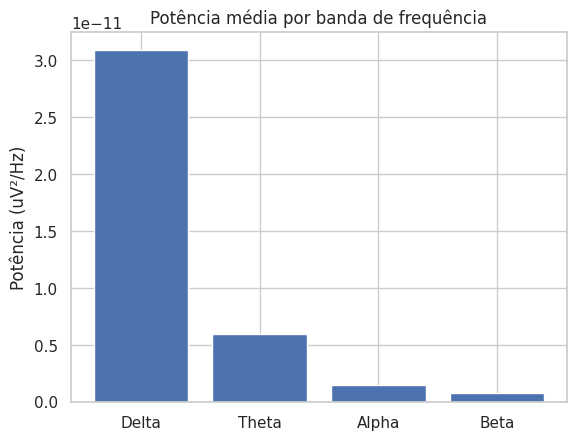

In [ ]:
## 🔍 Frequency Band Analysis (Delta, Theta, Alpha, Beta)

bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}

band_powers = {}
for band, (low, high) in bands.items():
    psd, freqs = PSD_FUNC(clean_signal.get_data(), sfreq=clean_signal.info['sfreq'], fmin=low, fmax=high)
    band_powers[band] = np.mean(psd)

plt.bar(band_powers.keys(), band_powers.values())
plt.title('Potência média por banda de frequência')
plt.ylabel('Potência (uV²/Hz)')
plt.show()


Mostrando as bandas filtradas para o canal: EEG FP1


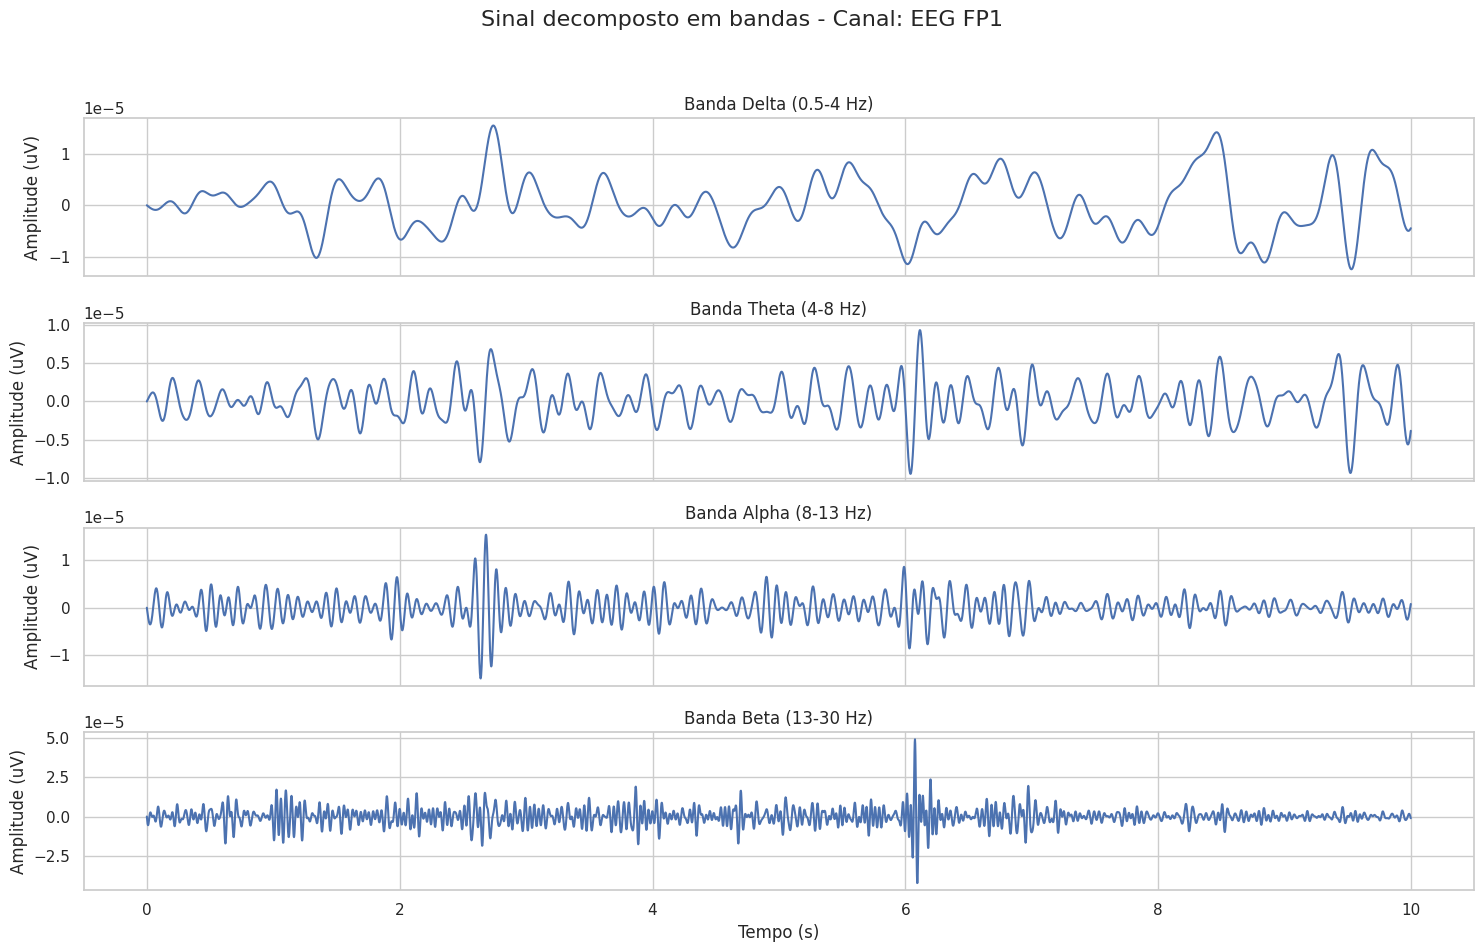

In [ ]:
import matplotlib.pyplot as plt
import mne

data_source = clean_signal

# 2. Pega os dados e a frequência de amostragem
data, times = data_source.get_data(return_times=True)
sfreq = data_source.info['sfreq']

# 3. Escolhe um canal para visualizar (ex: o primeiro canal, índice 0)
#    Plotar todos os 52 canais ficaria muito poluído.
channel_index = 0
channel_name = data_source.info['ch_names'][channel_index]
data_ch = data[channel_index]

print(f"Mostrando as bandas filtradas para o canal: {channel_name}")

# 4. Define as bandas (você já tem isso)
bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}

# 5. Cria 4 subplots (um para cada banda)
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# 6. Limita o tempo de visualização para o gráfico ficar legível (ex: 10 segundos)
time_limit_sec = 10
sample_limit = int(time_limit_sec * sfreq)

# 7. Itera, filtra e plota
for ax, (band, (low, high)) in zip(axes, bands.items()):

    # Filtra o array de dados daquele canal
    # (Usamos 'mne.filter.filter_data' para filtrar o array numpy diretamente)
    filtered_data = mne.filter.filter_data(data_ch, sfreq, l_freq=low, h_freq=high,
                                           fir_design='firwin', verbose=False)

    # Plota os primeiros 10 segundos do sinal filtrado
    ax.plot(times[:sample_limit], filtered_data[:sample_limit])
    ax.set_title(f'Banda {band} ({low}-{high} Hz)')
    ax.set_ylabel('Amplitude (uV)')

axes[-1].set_xlabel('Tempo (s)')
plt.suptitle(f'Sinal decomposto em bandas - Canal: {channel_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para o super-título
plt.show()

In [ ]:
## 🧭 Topographic Visualization

# Compute PSD for topomap visualization
psds, freqs = PSD_FUNC(raw,  sfreq=raw.info['sfreq'], fmin=8, fmax=13, n_fft=2048)
psd_mean = np.mean(psds, axis=1)

# Create topomap
mne.viz.plot_topomap(psd_mean, raw.info, cmap='viridis', contours=0)
plt.title('Topografia da Banda Alfa (8–13 Hz)')
plt.show()


AttributeError: 'RawEDF' object has no attribute 'shape'